<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.0


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [4]:
#Loading data
data= pd.read_csv("NER dataset.csv",encoding="latin1")

In [5]:
#Looking for null values
print(data.isnull().sum())

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [6]:
#Filling Null Values
data = data.fillna(method='ffill')
data.head()

Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O

In [7]:
print("Unique Words in corpus:",data['Word'].nunique())
print("Unique Tag in corpus:",data['Tag'].nunique())

Unique Words in corpus: 35178
Unique Tag in corpus: 17


In [8]:
#Storing unique words and tags as a list
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

In [9]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

In [10]:
num_words, num_tags

(35179, 17)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [11]:
#Creating a class to get data in desired formate. i.e. Word,POS,Tag
class SentanceGetter(object):
  def __init__(self,data):
    self.n_sent = 1 #counter
    self.data = data
    agg_func = lambda s:[(w,p,t) for w,p,t in zip(s['Word'].tolist(),s['POS'].tolist(),s['Tag'].tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentances = [s for s in self.grouped]

In [12]:
getter = SentanceGetter(data)
sentances = getter.sentances

In [13]:
sentances[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [14]:
word2idx =  {w : i+1 for i,w in enumerate(words)}
tag2idx  =  {t : i for i,t in enumerate(tags)}

In [15]:
tag2idx

{'B-per': 0,
 'I-geo': 1,
 'B-nat': 2,
 'I-gpe': 3,
 'I-per': 4,
 'I-tim': 5,
 'B-eve': 6,
 'I-art': 7,
 'I-org': 8,
 'B-geo': 9,
 'B-gpe': 10,
 'I-eve': 11,
 'I-nat': 12,
 'B-org': 13,
 'B-tim': 14,
 'B-art': 15,
 'O': 16}

In [16]:
word2idx

{'prepared': 1,
 'Bassel': 2,
 'conductive': 3,
 'Jennifer': 4,
 'Fayez': 5,
 'demilitarized': 6,
 'Devices': 7,
 'posses': 8,
 'anti-proliferation': 9,
 'nuclear-free': 10,
 'gamble': 11,
 'build': 12,
 'bargain': 13,
 'swapping': 14,
 'rumors': 15,
 'Ronnie': 16,
 'Numerous': 17,
 'track': 18,
 'sworn-in': 19,
 'egg': 20,
 'Polish': 21,
 'straight-sets': 22,
 'survival': 23,
 'St.': 24,
 'post-recession': 25,
 'me': 26,
 'Berkeley': 27,
 'Ticketing': 28,
 '5.9': 29,
 'Badgesty': 30,
 'reorganized': 31,
 'territories': 32,
 'Kite': 33,
 'shortage': 34,
 'Ecuadorian': 35,
 'CARTER': 36,
 'misguided': 37,
 'Kohistan': 38,
 'Four': 39,
 '17.9': 40,
 'Waheed': 41,
 "Ba'ath": 42,
 'gambled': 43,
 'wood': 44,
 'Medvedev': 45,
 '332': 46,
 'balking': 47,
 'Wolf': 48,
 'asthma': 49,
 'unprotected': 50,
 'gratitude': 51,
 'fourth': 52,
 'Nick': 53,
 'bulldozing': 54,
 'honoring': 55,
 'Danai': 56,
 'Sebastian': 57,
 'anti-U.S.': 58,
 'Iraqna': 59,
 'et': 60,
 '1,247': 61,
 'Import-Export': 62,

### Task 5: Padding Input Sentences and Creating Train/Test Splits


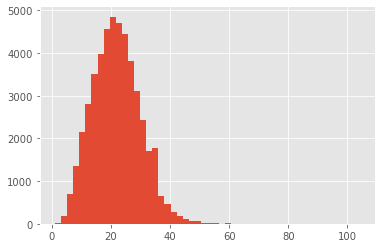

In [17]:
plt.hist([len(s) for s in sentances], bins=50)
plt.show()

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s]for s in sentances]
X = pad_sequences(maxlen = max_len , sequences =X, padding='post', value =num_words-1)

y = [[tag2idx[w[2]] for w in s]for s in sentances]
y = pad_sequences(maxlen = max_len , sequences =y, padding='post', value =tag2idx["O"])
print(y.shape)
y = [to_categorical(i, num_classes=num_tags) for i in y]

(47959, 50)


In [19]:
y

[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.

In [20]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.1,random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [21]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [22]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags,activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [23]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

### Task 7: Train the Model

In [24]:
!pip install livelossplot

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

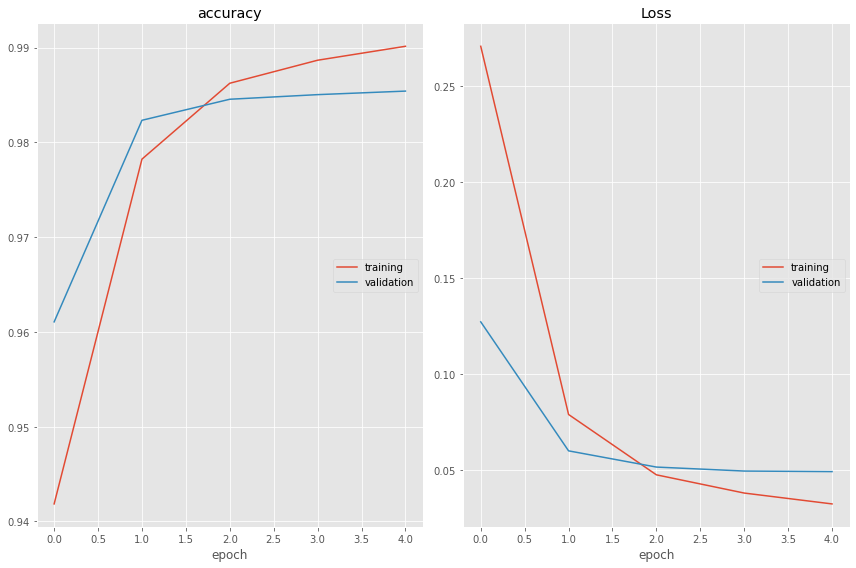

accuracy
	training         	 (min:    0.942, max:    0.990, cur:    0.990)
	validation       	 (min:    0.961, max:    0.985, cur:    0.985)
Loss
	training         	 (min:    0.032, max:    0.271, cur:    0.032)
	validation       	 (min:    0.049, max:    0.127, cur:    0.049)
540/540 [==============================] - 65s 121ms/step - loss: 0.0323 - accuracy: 0.9901 - val_loss: 0.0491 - val_accuracy: 0.9854


In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks = [PlotLossesCallback(),early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split = 0.2,
    batch_size = 64,
    epochs = 5,
    verbose = 1,
    callbacks=callbacks
)

### Task 8: Evaluate Named Entity Recognition Model

In [27]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 2s 12ms/step - loss: 0.0506 - accuracy: 0.9851


[0.05055754631757736, 0.9851334691047668]

In [28]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}\n".format("Word","True","Pred"))
print("-"*30)
count=0
sentence=''
for w,true,pred in zip(x_test[i], y_true, p[0]):
    count+=1
    if(count>20):
        break
    sentence+=words[w-1]+" "
    print("{:15}{:5}\t{}".format(words[w-1], tags[true],tags[pred]))
print(sentence)

Word           True 	 Pred

------------------------------
The            O    	O
United         B-geo	B-geo
States         I-geo	I-geo
has            O    	O
103            O    	O
nuclear        O    	O
power          O    	O
plants         O    	O
in             O    	O
31             O    	B-tim
states         O    	O
.              O    	O
self-sufficiencyO    	O
self-sufficiencyO    	O
self-sufficiencyO    	O
self-sufficiencyO    	O
self-sufficiencyO    	O
self-sufficiencyO    	O
self-sufficiencyO    	O
self-sufficiencyO    	O
The United States has 103 nuclear power plants in 31 states . self-sufficiency self-sufficiency self-sufficiency self-sufficiency self-sufficiency self-sufficiency self-sufficiency self-sufficiency 


## Result is verified using Spacy Library

In [29]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_sm")
text1= NER(sentence)
displacy.render(text1,style="ent",jupyter=True)

In [31]:
print(sentence)

The United States has 103 nuclear power plants in 31 states . self-sufficiency self-sufficiency self-sufficiency self-sufficiency self-sufficiency self-sufficiency self-sufficiency self-sufficiency 
